In [1]:
%matplotlib widget
import time

import matplotlib.pyplot as plt
import numpy as np
import random
from src.v2.impl.conditions import StepCountCondition, PrecisionCondition, AbsolutePrecisionCondition, EpochCountCondition
from src.v2.impl.function_interpretations import LinearInterpretation, PolynomialInterpretation, MultiLinearInterpretation
from src.v2.impl.loss_functions import MSE, LineBinary
from src.v2.impl.methods import CoordinateDescent, GoldenRatioMethod, NewtonWolfe
from src.v2.impl.metrics import StepCount, CallCount, GradientCallCount, HessianCallCount, PrecisionCount, \
    AbsolutePrecisionCount, AbsolutePrecision, MinAbsolutePrecision, RAMSize, ExecutionTime, EpochCount
from src.v2.impl.oraculs import LambdaOracul, SymbolOracul, MinimisingOracul
from src.v2.runner.debug import FULL_DEBUG
from src.v2.runner.runner import Runner, FULL_VISUALIZE, NO_VISUALIZE, FULL_ANIMATION, VISUALIZE_FUNCTION, VISUALIZE
from src.v2.visualization.animation import Animator
from src.v2.runner.runner import TABLE
from src.v2.impl.methods import GradientDescent, ScipyMethod, Newton, NewtonBase
from IPython.display import display, HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))


def print_points(data):
    for i in data:
        print(i[0] + i[1])

In [2]:
metrics_base = [StepCount(), CallCount(), GradientCallCount()] # убрать stepCount

minPrec = 1e-5
defPrec = 1e-9
maxPrec = 1e-11

animations = [Animator()]

conditions = [StepCountCondition(500), PrecisionCondition(defPrec)] # replace with EpochCountCondition (пока не работает)

modules = ([ExecutionTime()]
           #+ [RAMSize()]
           + [EpochCount()]
           + metrics_base # loss бы добавить в вывод после обучения как метрику
           + conditions
           + [Animator()]
           )
methods = [GradientDescent(learning_rate=100, aprox_dec=1e-11)]
point = np.array([10.2, 32.5, 2.0])

Для начала зададим генератор для порождения простейших данных. Данная функция призвана генерировать набор точек, согласно заданной функции, зашумляя данные. Именно на предоставленных ей массивах будет тестироваться базовая работоспособность и вычислительная эффективность функций

In [3]:
def noised_data_generator(func, num, begin, end, noise_range) :
    res = []
    for i in range(0, num):
        point = random.uniform(begin, end)
        res += [[point, func(point) + random.uniform(-noise_range, noise_range)]]
    return res

In [4]:
linear_data1 = noised_data_generator(lambda x: 6*x+10, 100, -1000, 100, 100)
sq_data1 = noised_data_generator(lambda x: 6*x**2+10*x+1, 100, -1000, 1000, 100)

In [5]:
linear_data = noised_data_generator(lambda x: 6*x+10, 100, -1000, 1000, 1000)
sq_data = noised_data_generator(lambda x: 6*x**2+10*x+1, 100, -1000, 1000, 1000)

Первый подпункт основного задания предполагает исследование изменений в поведении метода SGD в зависимости от параметра batch_size. Для демонстрации как данной изменчивости, так и работоспособности алгоритма на практике (не стоит забывать, что его работа носит вероятностный характер, в отличие от метода градиентного спуска) рассмотрение данных особенностей будет происходить на реализованной силами данной команды реализации SGD, в силу наибольшей её приближённости к академическому представлению работы данного метода, что позволяет рассматривать подобные аспекты вне контекста практических приложений (таких как особенности работы в рамках обучения именно нейросетевых моделей, как в библиотеке tensorflow, использующейся в специфических разделах даной работы)

In [6]:
point = np.array([10.2, 32.5, 2.0])
linear_min_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, 1)
linear_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, 20)
linear_max_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, len(linear_data))
point = np.array([10.2, 32.5, 2.0])
polynomial_min_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, 1)
polynomial_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, 20)
polynomial_max_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, len(sq_data))



MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+---------------------+
| Method name                                      |   ExecutionTime |   EpochCount |   StepCount |   CallCount |   GradientCallCount |   AbsolutePrecision |
+==================================================+=================+==============+=============+=============+=====================+=====================+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |        0.883008 |            2 |         200 |       13000 |                 200 |             42.0784 |
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+---------------------+

MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+---------------------+
| Method name   

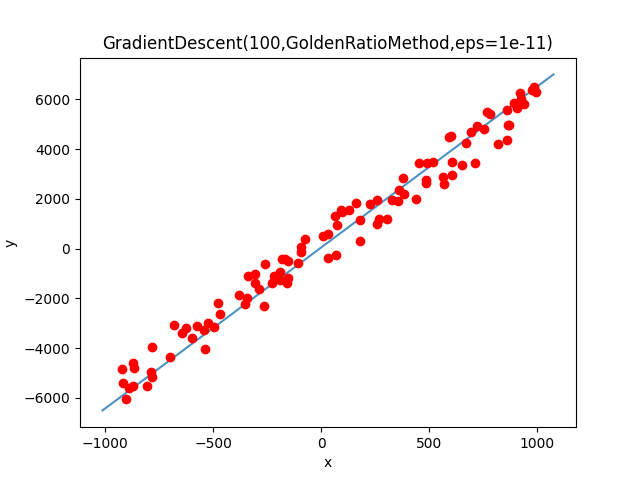

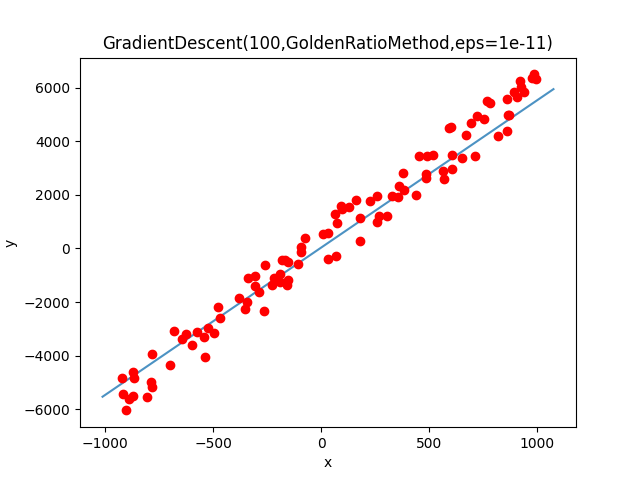

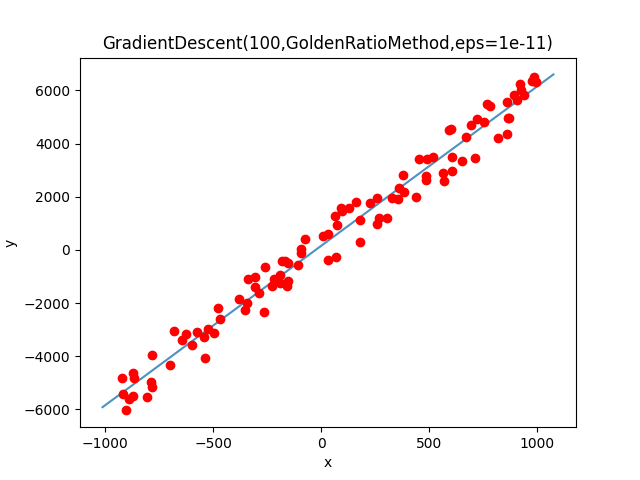

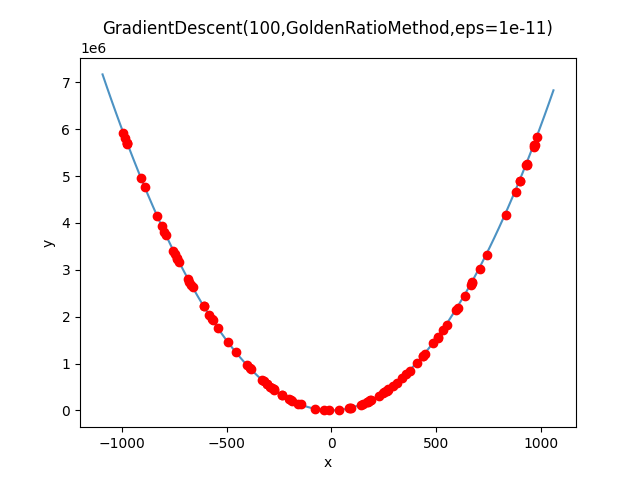

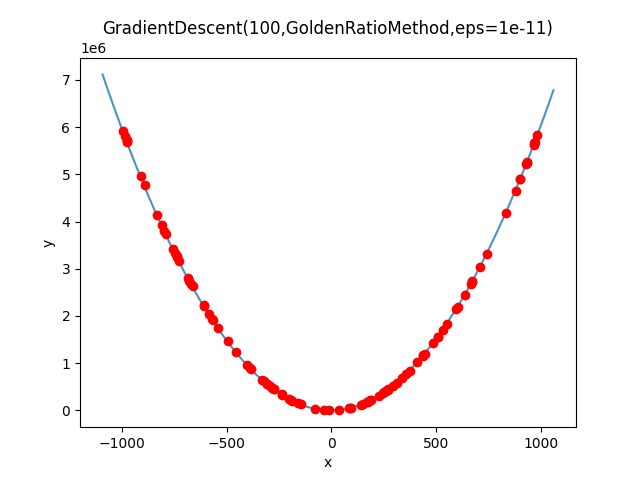

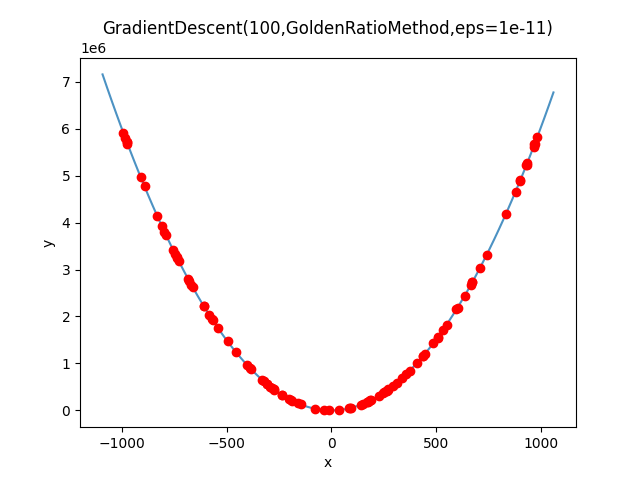

In [7]:
st = time.time()
result = Runner.run(methods, [linear_min_oracul, linear_oracul, linear_max_oracul, polynomial_min_oracul, polynomial_oracul, polynomial_max_oracul], point, modules, precision=defPrec,
                 # **FULL_DEBUG,
                 **TABLE,
                 **VISUALIZE,
                 # **FULL_VISUALIZE,
                 # **FULL_ANIMATION,
                 **VISUALIZE_FUNCTION
                 )

print(time.time() - st)

Поведение метода в целом соответствует ожиданиям. При минимальном размере существенно снижается время обучения, тем не менее значительно страдает точность. Даже на графиках заметно существенное отклонение от целевой функции. Другой крайностью является взятие в качестве batch_size размера выборки(фактически градиентный спуск): несмотря на существенное возрастание времени обучения, улучшения точности незначительны в сравнении с представителем промежуточного batch_size. Таким образом, подтверждается теоритическое предположение о большей вычислительной эффективности SGD в сравнении с GD при незначительной потере точности.
Также стоит заметить, что поведение методов сходно для случаев регрессии разных целевых функций, что является ожидаемым,  ведь подобный переход представляет из себя лишь добавление одного параметры

Тем не менее, стоит проверить, сохранится ли поведение методов на более сложных задачах. В качестве подобной задачи рассмотрим проблему поиска прямой, разделяющей два множества. Для начала, сгенерируем множества

In [40]:
import matplotlib.pyplot as plt
def gen_areas(per_class, areas):
    res = []
    counter = 0
    for i in areas:
        for j in range(per_class):
            res += [[random.uniform(i[0], i[1]), random.uniform(i[2], i[3]), counter]]
        counter += 1
    return res
def get_data(temp, dim):
    x = []
    y = []
    for j in temp:
        if j[2] == dim:
            x += [j[0]]
            y += [j[1]]
    return x, y

temp = gen_areas(100, [[-100, 100, -100, 100], [200, 500, 200, 500]])

In [9]:
conditions = [StepCountCondition(500)]
modules = ([ExecutionTime()]
           #+ [RAMSize()]
           + [EpochCount()]
           + metrics_base
           + conditions
           + [Animator()]
           )
primal_classes_oracul = MinimisingOracul(LineBinary(), LinearInterpretation(), temp, 25)
result = Runner.run([GradientDescent(learning_rate=100, aprox_dec=1e-11)], [primal_classes_oracul], np.array([0, 40]), modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    #**VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    #**VISUALIZE_FUNCTION
                    )

NameError: name 'temp' is not defined

In [52]:
def get_line_p(data):
    interpreter = LinearInterpretation()
    return [interpreter.interpret(data[0][0][0][1], np.array([1000])), interpreter.interpret(data[0][0][0][1], np.array([-200]))]
def visualize(data, res):
    line = get_line_p(res)
    x, y = get_data(data, 0)
    axes = plt.figure().add_subplot()
    plt.axline([line[0][0], line[1][0]], [line[0][1], line[1][1]])
    axes.scatter(x, y, c ="green")
    x, y = get_data(data, 1)
    axes.scatter(x, y, c = "yellow") 
    plt.show()

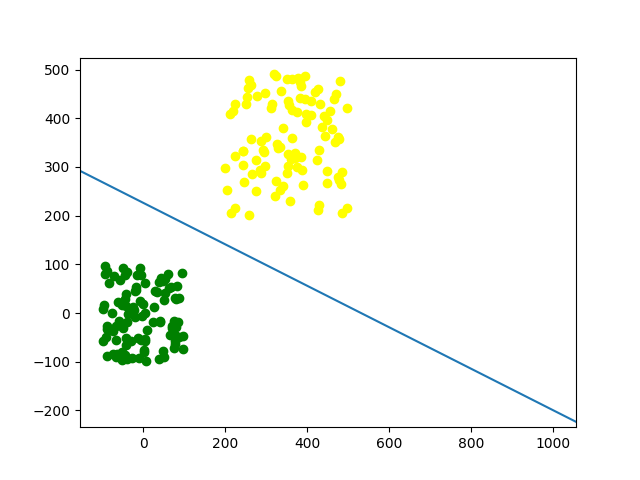

In [56]:
visualize(temp, result)

Последней из тестовых выборок для данного сегмента будет являться датасет регрессии. Задача - определение расхода топлива на милю по характеристикам машины.

In [3]:
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset = dataset[['Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'MPG']]
dataset = dataset.dropna()

In [5]:
data_normal=(dataset-dataset.mean())/dataset.std()
data_normal.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,MPG
393,-0.862911,-0.519972,-0.479835,-0.220842,0.021267,1.634321,-0.715726,0.455359
394,-0.862911,-0.930889,-1.363154,-0.997859,3.283479,1.634321,0.525711,2.633448
395,-0.862911,-0.567753,-0.531795,-0.803605,-1.428605,1.634321,-0.715726,1.095974
396,-0.862911,-0.711097,-0.661694,-0.415097,1.108671,1.634321,-0.715726,0.583482
397,-0.862911,-0.720653,-0.583754,-0.303253,1.398646,1.634321,-0.715726,0.967851


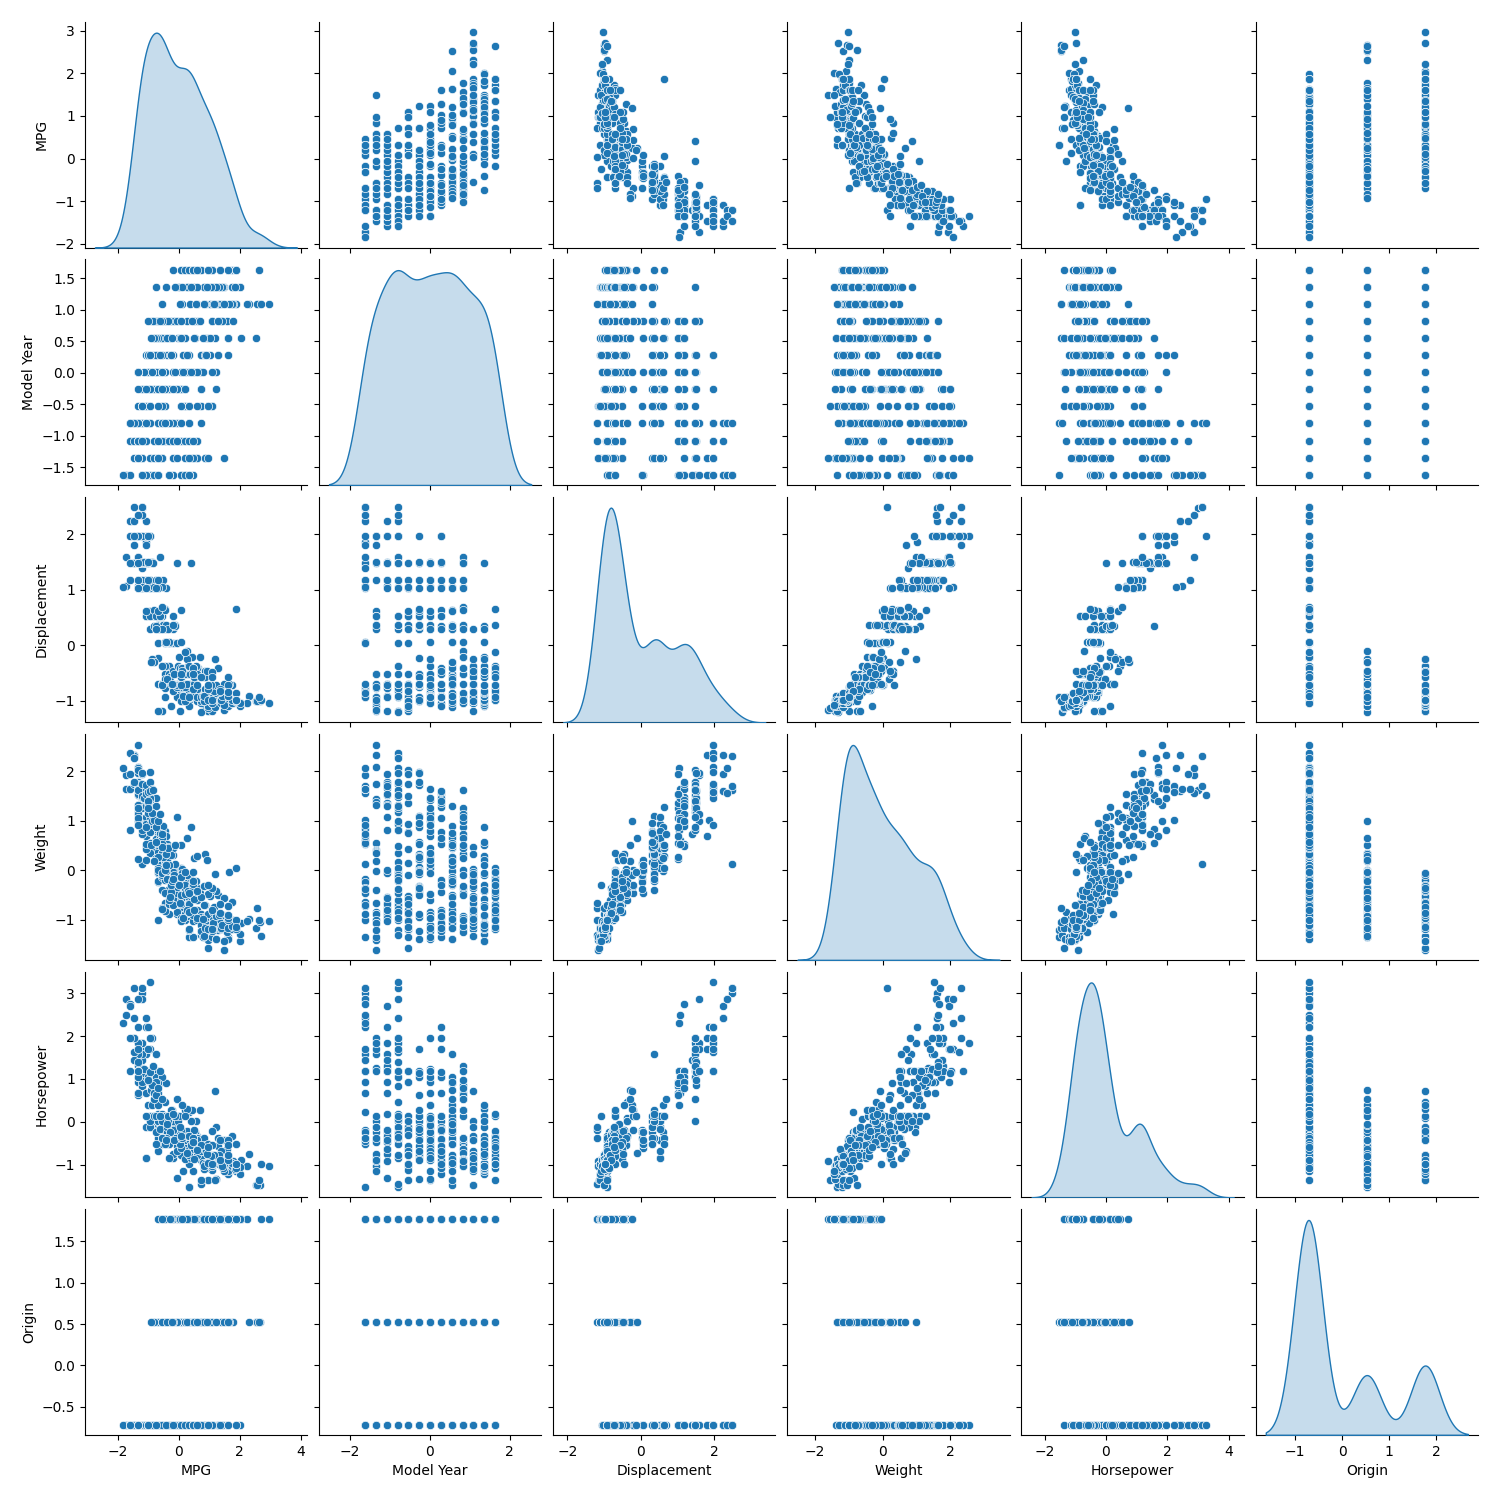

In [53]:
import seaborn as sns
sns.pairplot(data_normal[['MPG', 'Model Year', 'Displacement', 'Weight', 'Horsepower', 'Origin']], diag_kind='kde')

In [6]:
data_normal_np = data_normal.to_numpy()
mpg_regress = MinimisingOracul(MSE(), MultiLinearInterpretation(7), data_normal_np, 20)
result = Runner.run([GradientDescent(learning_rate=100, aprox_dec=1e-11)], [mpg_regress], np.array([1, 1, 1, 1, 1, 1, 1, 1]), modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    #**VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    #**VISUALIZE_FUNCTION
                    )


MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+
| Method name                                      |   ExecutionTime |   EpochCount |   StepCount |   CallCount |   GradientCallCount |
+==================================================+=================+==============+=============+=============+=====================+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |         66.5528 |           24 |         499 |       32435 |                 499 |
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+


In [52]:
dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,MPG
0,8,307.0,130.0,3504.0,12.0,70,1,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,1,27.0
394,4,97.0,52.0,2130.0,24.6,82,2,44.0
395,4,135.0,84.0,2295.0,11.6,82,1,32.0
396,4,120.0,79.0,2625.0,18.6,82,1,28.0


In [7]:
result

[[[('no_show_value',
    array([-0.14527419,  0.2872357 , -0.10537984, -0.72012848, -0.02218069,
            0.33803917,  0.17412483,  0.04154455])),
   ('Method name', 'GradientDescent(100,GoldenRatioMethod,eps=1e-11)'),
   ('ExecutionTime', 66.55281639099121),
   ('EpochCount', 24),
   ('StepCount', 499),
   ('CallCount', 32435),
   ('GradientCallCount', 499)]]]

In [46]:
MultiLinearInterpretation(7).interpret(np.array([-0.14527419,  0.2872357 , -0.10537984, -0.72012848, -0.02218069,
            0.33803917,  0.17412483,  0.04154455]), data_normal_np[8][0:7])

array([ 1.48205303,  2.49023356,  3.13138426,  1.70403986, -2.00855363,
       -1.6232409 , -0.71572638, -1.64438156])